In [1]:
from model import *
from data import *
from helpers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from torch.utils.data import DataLoader, Dataset
import sys
import time
import os

In [19]:
torch.nan

nan

In [13]:
class CorDec(pl.LightningModule):
    """
    Neural network for the entire variational autoencoder
    """
    def __init__(self,
                 dataloader,
                 nitems: int,
                 latent_dims: int,
                 qm: torch.Tensor,
                 learning_rate: float,
                 batch_size: int,
                 beta: int = 1,
                 n_samples: int = 1,
                 sigma_1=None,
                 cor_theta:bool=False):
        """
        Initialisaiton
        :param latent_dims: number of latent dimensions
        :param qm: IxD Q-matrix specifying which items i<I load on which dimensions d<D
        """
        super(CorDec, self).__init__()
        #self.automatic_optimization = False
        self.nitems = nitems
        self.latent_dims = latent_dims

        self.dataloader = dataloader

        #self.transform = LowerTriangularLayer(latent_dims)
        self.transform = nn.Identity()

        self.cor_post = False

        self.decoder = Decoder(nitems, latent_dims, qm)

        self.lr = learning_rate
        self.batch_size = batch_size
        self.beta = beta
        self.kl = 0
        self.n_samples = n_samples

    def forward(self, theta: torch.Tensor):
        """
        forward pass though the entire network
        :param x: tensor representing response data
        :param m: mask representing which data is missing
        :return: tensor representing a reconstruction of the input response data
        """

        # reshape mu and log sigma in order to take multiple samples

        z_transformed = self.transform(theta)
        reco = self.decoder(z_transformed)
        return (reco, z_transformed)


    def configure_optimizers(self):
        #return torch.optim.Adam(self.parameters(), lr=self.lr, amsgrad=True)
        return torch.optim.SGD(self.parameters(), lr=self.lr)


    def training_step(self, batch, batch_idx):
        # forward pass

        #if self.transform.L.grad is not None:
            #print(self.transform.L.grad.mean())
            #print(self.encoder.dense1.weight.grad.mean())
            #print(self.transform.L.mean())
            #print(self.encoder.dense1.weight.mean())


        theta, data = batch
        theta = theta.unsqueeze(0)

        reco,  z = self(theta)

        loss = self.loss(data, reco)
        self.log('train_loss',loss)

        return {'loss': loss}

    def train_dataloader(self):
        return self.dataloader

    def loss(self, input, reco):
        # calculate log likelihood
        #input = input.unsqueeze(0).repeat(reco.shape[0], 1, 1) # repeat input k times (to match reco size)
        log_p_x_theta = ((input * reco).clamp(1e-7).log() + ((1 - input) * (1 - reco)).clamp(1e-7).log()) # compute log ll
        logll = (log_p_x_theta).sum(dim=-1, keepdim=True) # set elements based on missing data to zero



        return -logll.mean()

In [14]:
with open("./config.yml", "r") as f:
    cfg = yaml.safe_load(f)
    cfg = cfg['configs']


In [40]:

a1 = K.constant(np.array([[.5, .4]]))
a2 =K.constant(np.array([[1,1]]))
binary_crossentropy(a1,a2, )

import torch
import torch.nn.functional as F
a1 = torch.Tensor(np.array([.5, .4]))
a2 = torch.Tensor(np.array([1,1]))
F.binary_cross_entropy(a1,a2)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([8.433281], dtype=float32)>

In [42]:
import torch
import torch.nn.functional as F
a1 = torch.Tensor(np.array([.5, .4]))
a2 = torch.Tensor(np.array([1,1]))
F.binary_cross_entropy(a1,a2)


tensor(0.8047)

In [15]:
mu_true = np.array([0, 0,0])
cov_true = np.array([1, .2, .5,
                     .2, 1, .4,
                     .5, .4, 1]).reshape((3,3))
theta = np.random.multivariate_normal(mu_true, np.eye(3), size=cfg['N'])
W = np.linalg.cholesky(cov_true)
W = np.repeat(W[np.newaxis, :, :], theta.shape[0], axis=0)
theta_cov = torch.bmm(torch.Tensor(W), torch.Tensor(theta).squeeze().unsqueeze(-1)).squeeze().detach().numpy()
Q = pd.read_csv(f'./QMatrices/QMatrix{cfg["mirt_dim"]}D.csv', header=None).values


a = np.random.uniform(.5, 2, Q.shape[0] * cfg['mirt_dim']).reshape((Q.shape[0], cfg['mirt_dim']))  # draw discrimination parameters from uniform distribution
a *= Q
b = np.linspace(-2, 2, Q.shape[0], endpoint=True)  # equally spaced values between -2 and 2 for the difficulty

exponent = np.dot(theta_cov, a.T) + b

prob = np.exp(exponent) / (1 + np.exp(exponent))
data = np.random.binomial(1, prob).astype(float)

theta_with_noise = theta + np.random.multivariate_normal(np.array([0,0,0]), np.eye(3)*.5, size=cfg['N'])

In [16]:
class SimDataset(Dataset):
    """
    Torch dataset for item response data in numpy array
    """
    def __init__(self, Theta, X, device='cpu'):
        """
        initialize
        """
        # Read csv and ignore rownames
    
        self.theta_train = torch.tensor(Theta, dtype=torch.float32)
        self.x_train = torch.tensor(X, dtype=torch.float32)
        

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.theta_train[idx], self.x_train[idx]


In [17]:

dataset = SimDataset(theta_with_noise, data)
train_loader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=True)

model = CorDec(nitems=data.shape[1],
           dataloader=train_loader,
           latent_dims=cfg['mirt_dim'],
           qm=Q,
           learning_rate=cfg['learning_rate'],
           batch_size=cfg['batch_size'],
           beta=cfg['beta'],
           n_samples=cfg['n_iw_samples'],
           sigma_1 = None,
           cor_theta=True)

logger = CSVLogger("logs", name='simfit', version=0)
trainer = Trainer(fast_dev_run=cfg['single_epoch_test_run'],
                  max_epochs=cfg['max_epochs'],
                  min_epochs=cfg['min_epochs'],
                  enable_checkpointing=False, 
                  logger=logger,
                  accelerator='cpu',
                  callbacks=[EarlyStopping(monitor='train_loss', min_delta=cfg['min_delta'], patience=cfg['patience'], mode='min')],
                  detect_anomaly=False)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [18]:
start = time.time()
trainer.fit(model)
runtime = time.time()-start
print(runtime)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:198: Experiment logs directory logs/simfit/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!

  | Name      | Type     | Params
---------------------------------------
0 | transform | Identity | 0     
1 | decoder   | Decoder  | 112   
---------------------------------------
112       Trainable params
0         Non-trainable params
112       Total params
0.000     Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Epoch 7:  44%|██████████▉              | 87/200 [00:00<00:00, 769.34it/s, v_num=0]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 68:  94%|█████████████████████▌ | 187/200 [00:00<00:00, 666.07it/s, v_num=0]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 81:  20%|████▋                   | 39/200 [00:00<00:00, 773.32it/s, v_num=0]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 89:  29%|██████▉                 | 58/200 [00:00<00:00, 763.64it/s, v_num=0]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 105: 100%|██████████████████████| 200/200 [00:00<00:00, 755.50it/s, v_num=0]
1973.0462310314178


In [8]:
W = model.transform.extract_cholesky_factor()
print(W@W.T)

print(torch.cov(torch.Tensor(theta_cov).T))

tensor([[1.0000, 0.2189, 0.4994],
        [0.2189, 1.0000, 0.4027],
        [0.4994, 0.4027, 1.0000]], grad_fn=<MmBackward0>)
tensor([[0.9869, 0.1960, 0.4811],
        [0.1960, 1.0066, 0.3987],
        [0.4811, 0.3987, 0.9932]])


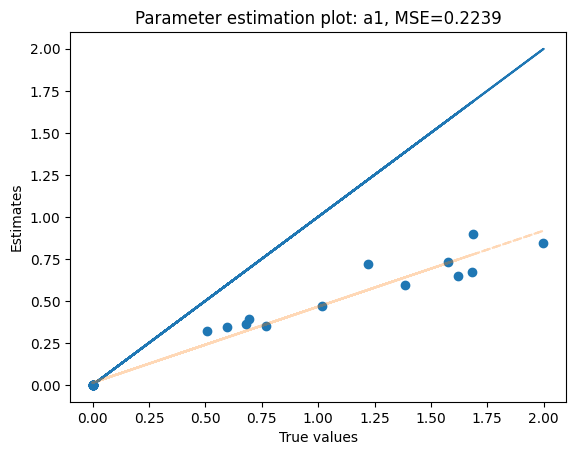

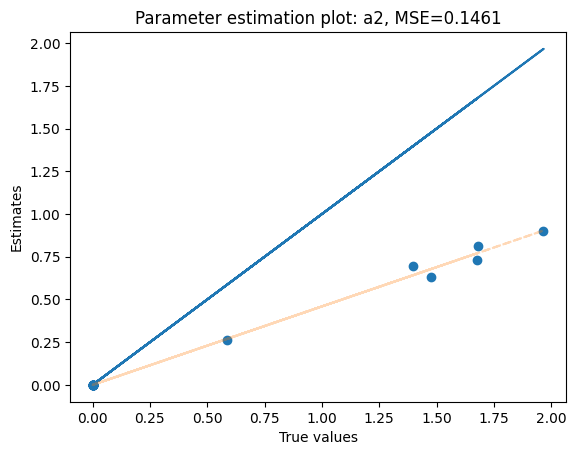

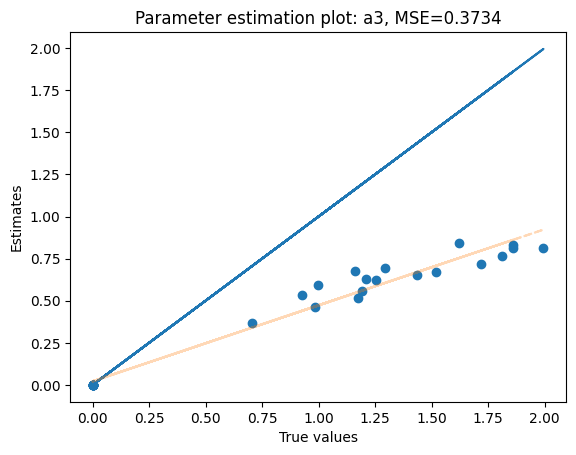

In [9]:
a_est = model.decoder.weights.t().detach().numpy()

for dim in range(cfg['mirt_dim']):
    plt.figure()

    ai_est = a_est[:,dim]
    ai_true = a[:,dim]

    mse = MSE(ai_est, ai_true)

    plt.scatter(y=ai_est, x=ai_true)
    plt.plot(ai_true, ai_true)
    slope, intercept = np.polyfit(ai_true, ai_est, 1)  # Get slope and intercept of the regression line
    plt.plot(ai_true, slope * np.array(ai_true) + intercept, '--', label='Regression Line', alpha=.3)  # Plot the regression line
    #for i, x in enumerate(ai_true):
    #    plt.text(ai_true[i], ai_est[i], i)
    plt.title(f'Parameter estimation plot: a{dim+1}, MSE={round(mse,4)}')
    plt.xlabel('True values')
    plt.ylabel('Estimates')
    plt.show()



In [20]:
import random
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K

import math as math
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.constraints import UnitNorm
from keras.layers import Lambda
from keras.losses import binary_crossentropy


##############
# Data generation
###############
N=1000                  # number of subjects
nit=60                  # number of items 
ndim=3                  #number of dimensions
nit_dim=int(nit/ndim)   #number of items per dimension
max_nepoch=5000        #max number of iterations

X=np.full((N,nit),999)      # empty matrix for item scores
prob=np.full((N,nit),0.99)   # empty matrix for probability correct
a=np.full((nit,ndim),0.0)      # empty matrix for discrimination parameters 

covMat=np.full((ndim,ndim),.3)  # covariance matrix of dimensions
np.fill_diagonal(covMat,1)
theta=np.random.multivariate_normal([0]*ndim,covMat,N)   # draw values for the dimensions

structure_matrix=np.full((nit,ndim),0.0)

for i in range(0,ndim):
    ax=np.random.uniform(.5,1.5,nit_dim)            #draw discrimination parameters from uniform distribution
    a[range(nit_dim*i, nit_dim*(i+1)),i] = ax
    structure_matrix[range(nit_dim*i, nit_dim*(i+1)),i]=1
structure_matrix = K.cast(K.transpose(structure_matrix),"float32")   # simple structure configuration

    
b=np.tile(np.linspace(-3,3,nit_dim,endpoint=True),ndim)   # decoder intercepts

for i in range(0,nit):
    for p in range(0,N):
        prob[p,i]=1/(1+math.exp(-(sum(a[i,:]*theta[p,:])+b[i])))       # probability correct
        X[p,i]=np.random.binomial(1,prob[p,i])                          # draw item scores on basis of prob correct


#############
# functions #
#############
#specify function to sample from latent dim
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=1)
    return z_mean + K.exp(z_log_sigma) * epsilon

# cov2cor

def cov2cor(x):
    sds=np.diag(1/np.sqrt(np.diag(x)))
    out=np.matmul(np.matmul(sds,x),sds)
    return out

#function to ensure simple structure
def a_reg2(a):
    b = a * structure_matrix
    return b

#function to introduce covariances
force_chol=K.cast(np.full((ndim,ndim),1),"float32")
force_chol1=K.cast(np.tril(force_chol,k=-1),"float32")
force_chol2=K.cast(np.diag([1]*ndim),"float32")

def c_reg(c):
    d= c*force_chol1
    e=d+force_chol2
    return e;   



##############
# Set up VAE
###############
encoding_dim=np.ceil((nit+ndim)/2)
latent_dim=ndim  #dimensions in VAE
batch_size=N  # sample size 


x=Input(batch_shape=(batch_size, nit))    # input layer
e1 = Dense(encoding_dim, activation='elu')(x)
z_mean = Dense(latent_dim,activation='linear')(e1)                   # specify person mean latent dim
z_log_sigma = Dense(latent_dim,activation='linear')(e1)              # specify person sd latent dim



#sample from latent dim
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

#encoder: connect the input to the latent dim parameters
encoder = Model(x, [z_mean, z_log_sigma, z])
       

# build decoder model
latent_inputs = Input(shape=(latent_dim,))  # input for the decoder model: the latent dimensions
outputs1 = Dense(latent_dim, activation='linear', kernel_constraint=c_reg,use_bias=False)(latent_inputs)  # the "cholesky layer"
outputs2 = Dense(nit, activation='sigmoid', kernel_constraint=a_reg2)(outputs1)  # connect input to output
 
 
# instantiate decoder model
decoder = Model(latent_inputs, outputs2)  # specify the decode model

# instantiate VAE model
outputs = decoder(encoder(x)[2])    # full output encoder -> decoder -> output
vae = Model(x, outputs)


# specify the loss function to estimate the model
reconstruction_loss = binary_crossentropy(x,outputs)   

reconstruction_loss *= nit
kl_loss = 1 + 2*z_log_sigma - K.square(z_mean) - K.exp(2*z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
 
# fit the model
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8,patience=500,verbose=1,mode="min")

hist=vae.fit(X, 
        epochs=100,
        batch_size=batch_size,verbose=0)

hist=vae.fit(X, 
        epochs=max_nepoch,
        batch_size=batch_size, verbose=1, callbacks=[callback])

loss=hist.history['loss']

pars=vae.get_weights()

theta_est = encoder(X)

##############
# Check correlations
###############

# this *should* give the correct correlations (all .3):
L=pars[-3]
print(cov2cor(np.matmul(L,np.transpose(L))))

#doesnt look like it. BUT:
    
np.corrcoef(np.transpose(np.matmul(theta_est[0],L)))

# using the biased lambdra matrix (L) and the estimates of mu
# from the latent variables (g), the actual latent variables (f) seem to have the correct correlations 

# dit krijg ik als correlaties (die negatieve cors zijn niet erg, komt doordat schaal is omgeklapt, 
# dat kan ik ook zien aan de item ladingen, die zijn negatief voor factor 1 en 3:
 #   array([[ 1.        , -0.30513961,  0.39002258],
 #          [-0.30513961,  1.        , -0.32839606],
 #          [ 0.39002258, -0.32839606,  1.        ]])
 
 # en uit R (lavaan):
 # f1 ~~                                               
 # f2                0.290    0.038    7.670    0.000
 # f3                0.374    0.038    9.968    0.000
#  f2 ~~                                               
#    f3                0.317    0.039    8.196    0.000
   
#lijkt heel aardig overeen te komen, mÃ¡Ã¡r het zijn geen schattingen, de schattingen zelf (in L) zijn biased.
#we moeten even nadenken hoe we dat willen oplossen (meerdere opties) 
     
#heel soms worden de off diagnal elements in L groter dan 1. Dit zou geen probleem moeten zijn, maar dan is de boel flinkt
# biased, bij mij kwam het 1x voor en toen waren de correlaties tussen de mu schattingen echt hoog. Hopelijk komt
# dat niet vaak voor en anders moeten we misschien zorgen dat die off-diagonal elements tussen de -1 en 1 blijven.

Epoch 1/5000
1/1 [==============================] - 0s 4ms/step - loss: 40.7600
Epoch 2/5000
1/1 [==============================] - 0s 3ms/step - loss: 40.7264
Epoch 3/5000
1/1 [==============================] - 0s 3ms/step - loss: 40.7256
Epoch 4/5000
1/1 [==============================] - 0s 3ms/step - loss: 40.7229
Epoch 5/5000
1/1 [==============================] - 0s 4ms/step - loss: 40.7191
Epoch 6/5000
1/1 [==============================] - 0s 3ms/step - loss: 40.6586
Epoch 7/5000
1/1 [==============================] - 0s 3ms/step - loss: 40.6438
Epoch 8/5000
1/1 [==============================] - 0s 3ms/step - loss: 40.6150
Epoch 9/5000
1/1 [==============================] - 0s 3ms/step - loss: 40.6171
Epoch 10/5000
1/1 [==============================] - 0s 2ms/step - loss: 40.6079
Epoch 11/5000
1/1 [==============================] - 0s 3ms/step - loss: 40.5869
Epoch 12/5000
1/1 [==============================] - 0s 3ms/step - loss: 40.5466
Epoch 13/5000
1/1 [==================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 2ms/step - loss: 31.1572
Epoch 1299/5000
1/1 [==============================] - 0s 2ms/step - loss: 31.0974
Epoch 1300/5000
1/1 [==============================] - 0s 2ms/step - loss: 31.1042
Epoch 1301/5000
1/1 [==============================] - 0s 2ms/step - loss: 31.1192
Epoch 1302/5000
1/1 [==============================] - 0s 2ms/step - loss: 31.0833
Epoch 1303/5000
1/1 [==============================] - 0s 2ms/step - loss: 31.1278
Epoch 1304/5000
1/1 [==============================] - 0s 2ms/step - loss: 31.1912
Epoch 1305/5000
1/1 [==============================] - 0s 2ms/step - loss: 31.1163
Epoch 1306/5000
1/1 [==============================] - 0s 2ms/step - loss: 31.1108
Epoch 1307/5000
1/1 [==============================] - 0s 2ms/step - loss: 31.0886
Epoch 1308/5000
1/1 [==============================] - 0s 3ms/step - loss: 31.1827
Epoch 1309/5000
1/1 [==============================] - 0s 2ms/step - loss: 31.1308
Epoch 1310/5000
1/1 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 2ms/step - loss: 28.7621
Epoch 3471/5000
1/1 [==============================] - 0s 3ms/step - loss: 28.7821
Epoch 3472/5000
1/1 [==============================] - 0s 3ms/step - loss: 28.7955
Epoch 3473/5000
1/1 [==============================] - 0s 3ms/step - loss: 28.8084
Epoch 3474/5000
1/1 [==============================] - 0s 2ms/step - loss: 28.7981
Epoch 3475/5000
1/1 [==============================] - 0s 3ms/step - loss: 28.7348
Epoch 3476/5000
1/1 [==============================] - 0s 3ms/step - loss: 28.8332
Epoch 3477/5000
1/1 [==============================] - 0s 2ms/step - loss: 28.7040
Epoch 3478/5000
1/1 [==============================] - 0s 3ms/step - loss: 28.7361
Epoch 3479/5000
1/1 [==============================] - 0s 3ms/step - loss: 28.7634
Epoch 3480/5000
1/1 [==============================] - 0s 2ms/step - loss: 28.6894
Epoch 3481/5000
1/1 [==============================] - 0s 3ms/step - loss: 28.7412
Epoch 3482/5000
1/1 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 2ms/step - loss: 27.9418
Epoch 4763/5000
1/1 [==============================] - 0s 2ms/step - loss: 27.9377
Epoch 4764/5000
1/1 [==============================] - 0s 2ms/step - loss: 27.9796
Epoch 4765/5000
1/1 [==============================] - 0s 2ms/step - loss: 27.9675
Epoch 4766/5000
1/1 [==============================] - 0s 2ms/step - loss: 27.9817
Epoch 4767/5000
1/1 [==============================] - 0s 2ms/step - loss: 27.9438
Epoch 4768/5000
1/1 [==============================] - 0s 2ms/step - loss: 28.0224
Epoch 4769/5000
1/1 [==============================] - 0s 2ms/step - loss: 28.0148
Epoch 4770/5000
1/1 [==============================] - 0s 2ms/step - loss: 27.9870
Epoch 4771/5000
1/1 [==============================] - 0s 2ms/step - loss: 27.9660
Epoch 4772/5000
1/1 [==============================] - 0s 2ms/step - loss: 28.0022
Epoch 4773/5000
1/1 [==============================] - 0s 2ms/step - loss: 28.0878
Epoch 4774/5000
1/1 

array([[1.        , 0.19967705, 0.39373489],
       [0.19967705, 1.        , 0.36903445],
       [0.39373489, 0.36903445, 1.        ]])

In [21]:
L=pars[-3]
print(cov2cor(np.matmul(L,np.transpose(L))))

#doesnt look like it. BUT:
    
np.corrcoef(np.transpose(np.matmul(theta_est[0],L)))

[[1.         0.04485804 0.25893503]
 [0.04485804 0.9999999  0.25477108]
 [0.25893503 0.2547711  1.        ]]


array([[1.        , 0.19967705, 0.39373489],
       [0.19967705, 1.        , 0.36903445],
       [0.39373489, 0.36903445, 1.        ]])

In [3]:
force_chol=K.cast(np.full((ndim,ndim),1),"float32")
force_chol1=K.cast(np.tril(force_chol,k=0),"float32")
force_chol1

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]], dtype=float32)>